# ETL notebook for the datapipeline and data preparation for Power BI dashboard

### 1. Load the files and get the first impression of them

In [1]:
# all required imports
import pandas as pd
import re
import os

# show all columns
pd.set_option('display.max_columns', None)

In [2]:
# Define the base path
base_path = os.path.join('..', 'raw_data')

In [3]:
# Read the files
df_online = pd.read_csv(os.path.join(base_path, 'AF_online_sales_dataset.csv'))
df_offline = pd.read_csv(os.path.join(base_path, 'AF_offline_sales_dataset.csv'))

### 2. Get the understanding about the columns in both datasets (each one has a different number of columns)

In [4]:
# columns in both dfs:
print(df_online.columns)
print(df_offline.columns)

Index(['tmstmp', 'product_category', 'product_subcategory', 'product',
       'brand_name', 'product_price', 'quantity_sold', 'total_amount',
       'total_costs', 'payment_type', 'shipping_method', 'coupon_discount',
       'customer_firstname', 'customer_lastname', 'customer_gender',
       'customer_age', 'customer_shirtsize', 'customer_email',
       'customer_phone', 'customer_address', 'address_details',
       'customer_city', 'customer_state', 'store_website',
       'employee_firstname', 'employee_lastname', 'employee_email',
       'employee_skill', 'employee_education'],
      dtype='object')
Index(['product_name', 'brand', 'category', 'subcategory', 'supplier', 'date',
       'price', 'quantity_sold', 'amount_sold', 'cost_amount',
       'payment_method', 'customer_firstname', 'customer_lastname',
       'customer_gender', 'customer_email', 'customer_phone', 'store_type',
       'store_street', 'store_city', 'store_state'],
      dtype='object')


### 3. Unite the datasets
### 4. Add a column to each dataset for online/offline sales (sales_channel)

In [5]:
# Standardize column names (renaming where necessary for the columns having similar business sense)
df_offline.rename(columns={
    'product_name': 'product',
    'brand': 'brand_name',
    'category': 'product_category',
    'subcategory': 'product_subcategory',
    'date': 'tmstmp',
    'price': 'product_price',
    'amount_sold': 'total_amount',
    'cost_amount': 'total_costs',
    'payment_method': 'payment_type'
}, inplace=True)

# Add missing columns and fill with None/NaN where necessary
missing_columns = set(df_online.columns) - set(df_offline.columns)
for col in missing_columns:
    df_offline[col] = None  # Fill missing columns in offline with None

missing_columns = set(df_offline.columns) - set(df_online.columns)
for col in missing_columns:
    df_online[col] = None  # Fill missing columns in online with None

# Add a sales channel column
df_online['sales_channel'] = 'Online'
df_offline['sales_channel'] = 'Offline'

# Concatenate both DataFrames
df_combined = pd.concat([df_online, df_offline], ignore_index=True)

# Sort the records by tmstmp
df_combined['tmstmp'] = pd.to_datetime(df_combined['tmstmp'], errors='coerce')  # optional but recommended
df_combined.sort_values(by='tmstmp', inplace=True)

# Reset index and add transaction_id
df_combined.reset_index(drop=True, inplace=True)
df_combined['transaction_id'] = df_combined.index + 1

### 5. Review what we've got

#### Observations
1. So, we got a united dataset with 1.034.000 records: 533.000 of which came from online sales dataset and 501.000 records from offline dataset
2. We have a number of columns which have values from one of the 2 datasets only:

    - Columns, containing data from Online sales dataset:
        - shipping_method      
        - coupon_discount      
        - customer_age         
        - customer_shirtsize   
        - customer_address     
        - address_details      
        - customer_city        
        - customer_state       
        - store_website        
        - employee_firstname   
        - employee_lastname    
        - employee_email       
        - employee_skill     
        - employee_education 
    
    - Columns, containing data from Offline sales dataset:
        - store_street         
        - supplier             
        - store_city           
        - store_state          
        - store_type  
3. Basically, it is up to us how we handle this issue. It is possible to apply some logic in order to fill the columns

### 5.1 Some assumptions and logic that could be applied:

    Online part of the data:
    1. shipping_method - it only exists in online part of the data, offline part can be filled with 'in-store pickup'
    2. coupon_discount - it only exists in online part of the data, offline part can be filled with 0
    3. customer_age - unfortunately we don't have a source of data for this column
    4. customer_shirtsize - unfortunately this column exists in online part of the data only, we won't have any for offline part
    5. customer_address - unfortunately we won't have this data for offline sales
    6. address_details - we won't have data for offline sales
    7. cusotmer_city - we can assume that most of the customers live in the city they conduct purchases, therefore we'll take values from store_city column (offline data) for offline purchases
    8. customer_state - same here, most customers buy in-stores in the states they live, so it will be taken from store_state
    9. store_website - this column will remain empty for offline part of the data
    
    It is quite weird that the online part of the data contains data about the employees and the offline doesn't, but we'll go with it, employee part of the final data will be available for online part of the data only
    10. employee_firstname - it will contain online data only
    11. employee_lastname - it will contain online data only
    12. employee_email - it will contain online data only
    13. employee_skill - it will contain online data only
    14. employee_education - it will contain online data only
    
    
    Offline part of the data:
    1. store_street - online part of the data will remain with null
    2. supplier - so, after checking the column in EDA notebook, it was seen that the column is quite useless...
    3. store_city - this column will contain data from offline stores only
    4. store_state - this column will contain data from offline stores only
    5. store_type - we'll take a look at the values this column contains, but we can fill the column with 'online' for the online part of the data

### 6. Transform the data according to valid logic

##### 6.1 shipping_method

In [9]:
#let's fill the column with values according to the chosen logic
df_combined.loc[df_combined['sales_channel'] == 'Offline', 'shipping_method'] =\
    df_combined.loc[df_combined['sales_channel'] == 'Offline', 'shipping_method'].fillna('instore_pickup')

##### 6.2 coupon_discount

In [6]:
#let's fill the column with values according to the chosen logic
df_combined.loc[df_combined['sales_channel'] == 'Offline', 'coupon_discount'] = \
    df_combined.loc[df_combined['sales_channel'] == 'Offline', 'coupon_discount'].fillna(0)

C:\Users\atans\AppData\Local\Temp\ipykernel_1296\1994261631.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_combined.loc[df_combined['sales_channel'] == 'Offline', 'coupon_discount'].fillna(0)


##### 6.3. cusotmer_city

In [7]:
# Fill customer_city with store_city values for Offline sales only
df_combined.loc[df_combined['sales_channel'] == 'Offline', 'customer_city'] = \
    df_combined.loc[df_combined['sales_channel'] == 'Offline', 'customer_city'].fillna(
        df_combined.loc[df_combined['sales_channel'] == 'Offline', 'store_city']
    )

#### 6.4.  customer_state

In [8]:
# Fill customer_city with store_state values for Offline sales only
df_combined.loc[df_combined['sales_channel'] == 'Offline', 'customer_state'] = \
    df_combined.loc[df_combined['sales_channel'] == 'Offline', 'customer_state'].fillna(
        df_combined.loc[df_combined['sales_channel'] == 'Offline', 'store_state']
    )

#### 6.5. store_type

In [9]:
#let's fill the column with values according to the chosen logic
df_combined.loc[df_combined['sales_channel'] == 'Online', 'store_type'] = \
    df_combined.loc[df_combined['sales_channel'] == 'Online', 'store_type'].fillna('online')

### 7. Plan a snowflake schema

#### So, after preparing the data for the schema stage, the structure will look like:

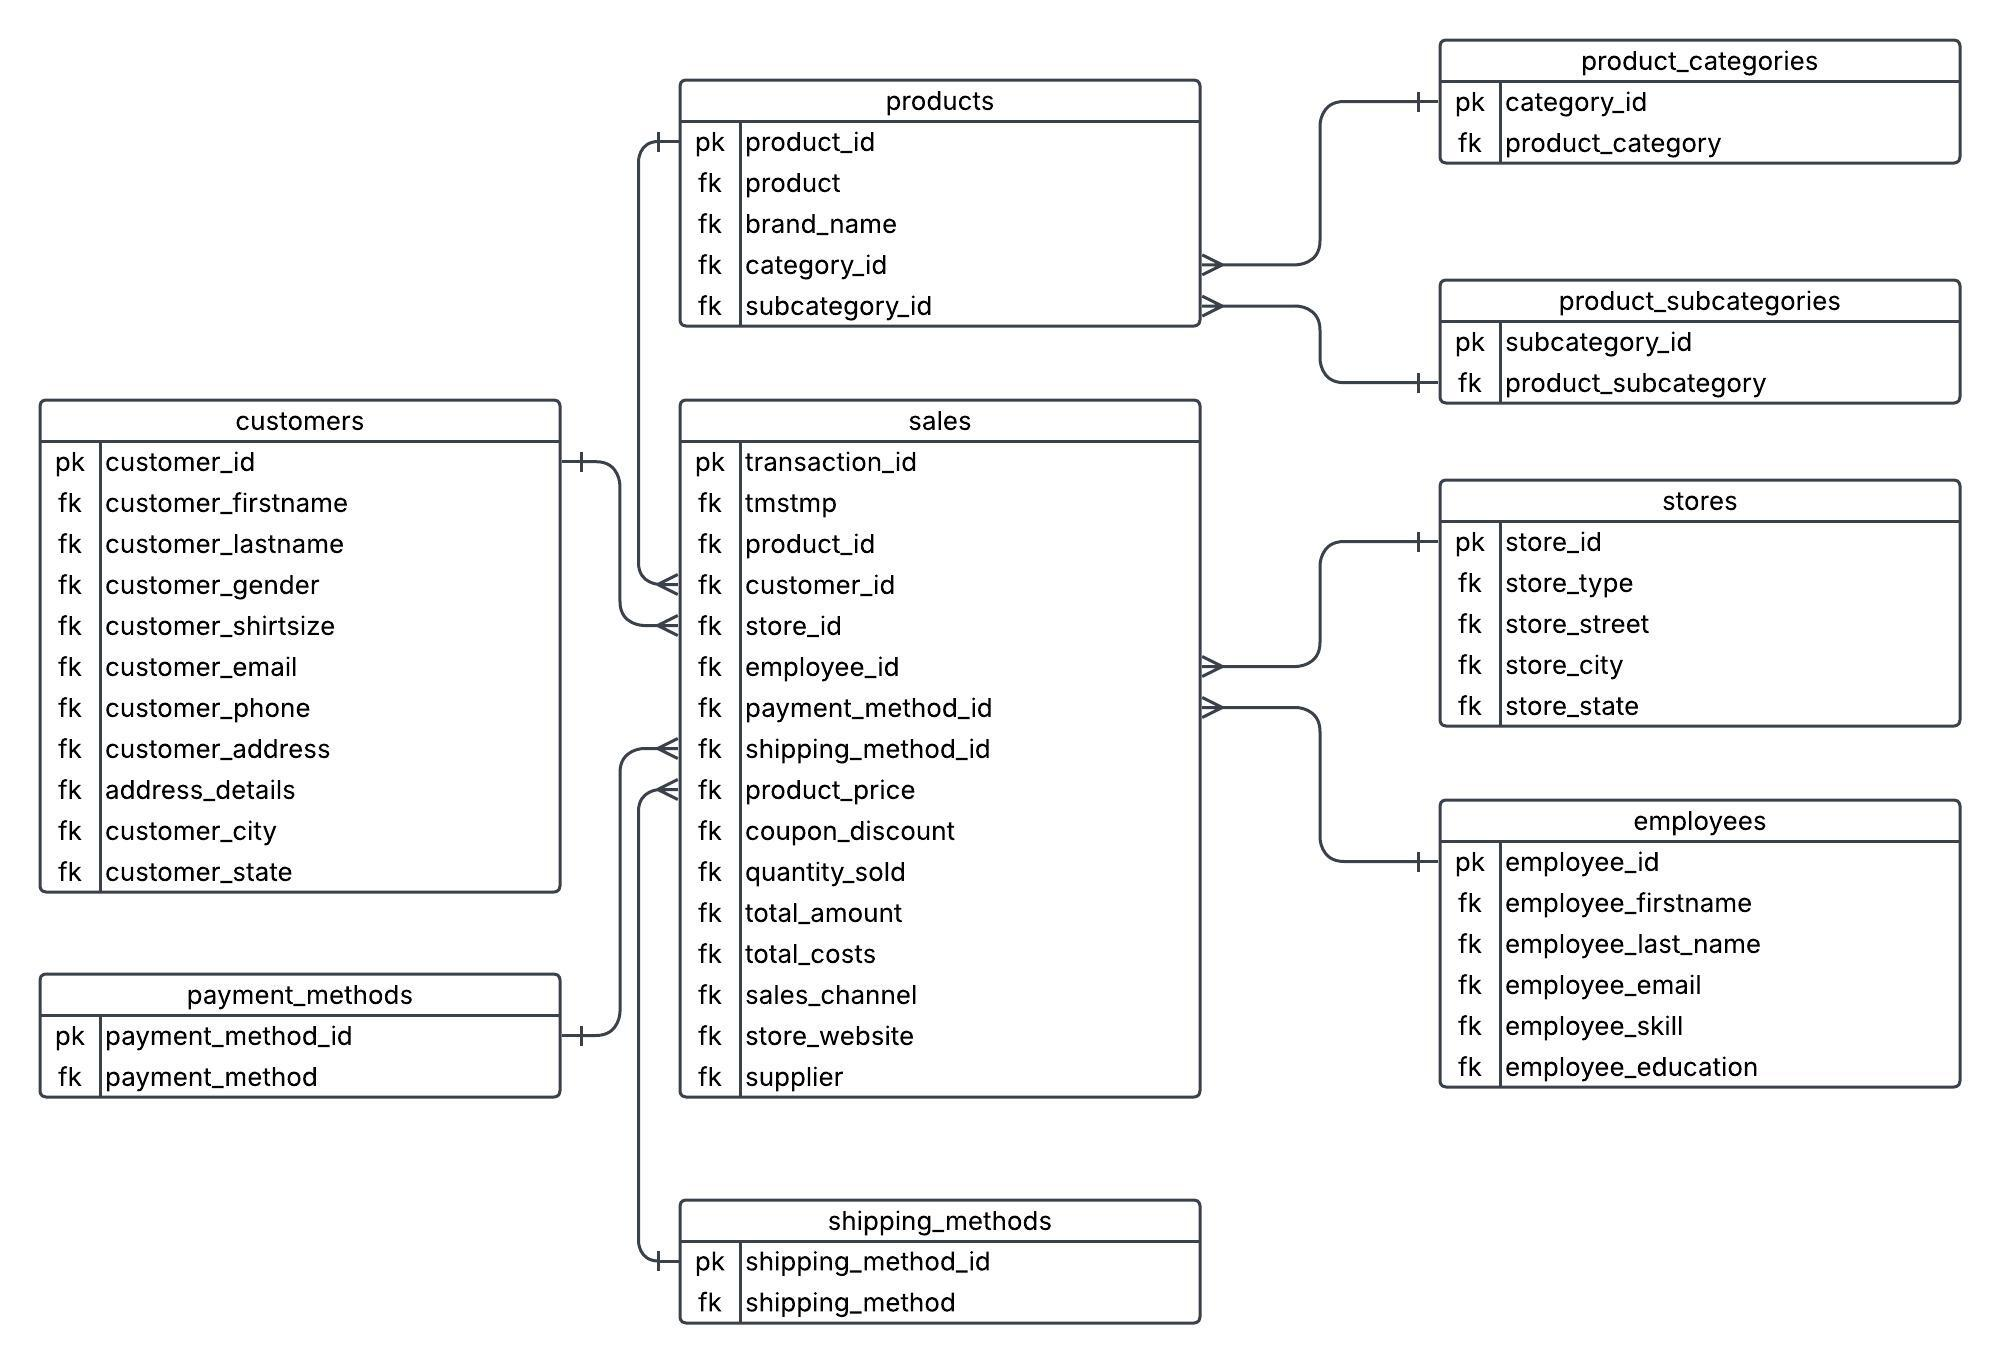

In [10]:
from IPython.display import Image, display

# Image is in the parent folder (one level up)
display(Image(filename='../snowflake_schema/schema.jpeg'))

### Conclusions and limitations:

    1. Supplier is not unique per any of the combinations of the features, so it remains in the fact table 'sales'
    2. Employees table will contain data for online sales only, as the original data didn't have any info about the offline sales staff
    3. The column product_price was decided to be in sales as the values of products looked quite random, so it is better for them to be in the fact table
    4. The brand_name column will be in products column as brand is unique per product, category and subcategory
    5. The rest should be fine

### 8. Build dimention and fact dataframes out of united dataframe

#### 🔹 8.1. Create `product_categories` dataframe

In [11]:
# create product_categories dataframe and sort values by product_category
product_categories = df_combined[['product_category']].drop_duplicates().sort_values(by='product_category').\
                    reset_index(drop=True)

# create a category_id column
product_categories['category_id'] = product_categories.index + 1

# reorder the columns so that it looks nice
product_categories = product_categories[['category_id', 'product_category']]

#### 🔹 8.2. Create `product_subcategories` dataframe

In [12]:
# create product_subcategories dataframe and sort values by product_subcategory
product_subcategories = df_combined[['product_subcategory']].drop_duplicates().\
                        sort_values(by='product_subcategory').reset_index(drop=True)

# create a subcategory_id column
product_subcategories['subcategory_id'] = product_subcategories.index + 1

# reorder the columns so that it looks nice
product_subcategories = product_subcategories[['subcategory_id', 'product_subcategory']]

#### 🔹 8.3. Create `products` dataframe

In [13]:
# create products dataframe and sort values by product
products = df_combined[['product', 'brand_name', 'product_category', 'product_subcategory']].drop_duplicates().\
           sort_values(by='product').reset_index(drop=True)

# merge for getting subcategory_id
products = products.merge(product_subcategories[['product_subcategory', 'subcategory_id']], on='product_subcategory')

# merge for getting category_id
products = products.merge(product_categories, on='product_category')

# create a product_id column
products['product_id'] = products.index + 1

# reorder the columns so that it looks nice
products = products[['product_id', 'product', 'brand_name', 'category_id', 'subcategory_id']]

#### 🔹 8.4. Create `customers` dataframe

In [14]:
# Function to format phone numbers
def format_phone(phone):
    phone = re.sub(r'\D', '', str(phone))  # Remove all non-numeric characters
    if len(phone) == 10:
        return f"{phone[:3]}-{phone[3:6]}-{phone[6:]}"  # Format as XXX-XXX-XXXX
    return phone  # Keep as-is if it doesn't match expected length

# Apply function to customer_phone column
df_combined['customer_phone'] = df_combined['customer_phone'].apply(format_phone)

# Create customers dataframe with formatted phones
customers = df_combined[['customer_firstname', 'customer_lastname', 'customer_gender', 'customer_email',
                         'customer_phone', 'customer_address', 'address_details', 'customer_city', 'customer_state']].\
            drop_duplicates().sort_values(by=['customer_firstname', 'customer_lastname']).reset_index(drop=True)

# create a customer_id column
customers['customer_id'] = customers.index + 1

# reorder the columns so that it looks nice
customers = customers[['customer_id', 'customer_firstname', 'customer_lastname', 'customer_gender', 
                       'customer_email', 'customer_phone', 'customer_address', 'address_details', 
                       'customer_city', 'customer_state']]

#### 🔹 8.5. Create `stores` dataframe

In [15]:
# create stores dataframe
stores = df_combined[['store_type', 'store_street', 'store_city', 'store_state']].drop_duplicates().\
         reset_index(drop=True)

# create a store_id column
stores['store_id'] = stores.index + 1

# reorder the columns so that it looks nice
stores = stores[['store_id', 'store_type', 'store_street', 'store_city', 'store_state']]

#### 🔹 8.6. Create `employees` dataframe

In [16]:
# create employees dataframe
employees = df_combined[['employee_firstname', 'employee_lastname', 'employee_email',\
                         'employee_skill', 'employee_education']].drop_duplicates().\
            sort_values(by=['employee_firstname', 'employee_lastname']).reset_index(drop=True)

# create an employee_id column
employees['employee_id'] = employees.index + 1

# reorder the columns so that it looks nice
employees = employees[['employee_id', 'employee_firstname', 'employee_lastname',\
                       'employee_email', 'employee_skill', 'employee_education']]

#### 🔹 8.7. Create `payment_methods` dataframe

In [17]:
# create payment_methods dataframe
payment_methods = df_combined[['payment_type']].drop_duplicates().sort_values(by='payment_type').reset_index(drop=True)

# rename payment_type to payment_method
payment_methods.rename(columns={'payment_type': 'payment_method'}, inplace=True)

# create payment_method_id column
payment_methods['payment_method_id'] = payment_methods.index + 1

# reorder the columns so that it looks nice
payment_methods = payment_methods[['payment_method_id', 'payment_method']]

#### 🔹 8.8. Create `shipping_methods` dataframe

In [18]:
# create shipping_methods dataframe
shipping_methods = df_combined[['shipping_method']].drop_duplicates().sort_values(by='shipping_method').\
                   reset_index(drop=True)

# create shipping_method_id column
shipping_methods['shipping_method_id'] = shipping_methods.index + 1

# reorder the columns so that it looks nice
shipping_methods = shipping_methods[['shipping_method_id', 'shipping_method']]

#### 🔹 8.9. Create `fact_sales` dataframe

In [19]:
# copy the relevant columns for the fact table
fact_sales = df_combined[['transaction_id', 'tmstmp', 'product', 'brand_name',
                          'customer_firstname', 'customer_lastname', 'customer_gender', 'customer_email',
                          'customer_phone', 'customer_address', 'address_details', 'customer_city', 'customer_state',
                          'store_type', 'store_street', 'store_city', 'store_state',
                          'employee_firstname', 'employee_lastname', 'employee_email', 'employee_skill', 'employee_education',
                          'payment_type', 'shipping_method', 'product_price', 'coupon_discount', 
                          'quantity_sold', 'total_amount', 'total_costs', 'sales_channel',
                          'store_website', 'supplier']].copy()

# merge products
fact_sales = fact_sales.merge(products[['product', 'product_id', 'brand_name']], on=['product', 'brand_name'],\
                              how='left')

# merge customers
fact_sales = fact_sales.merge(customers[['customer_firstname', 'customer_lastname', 'customer_gender',\
                                         'customer_email', 'customer_phone', 'customer_address', 'address_details',\
                                         'customer_city', 'customer_state', 'customer_id']],\
                              on=['customer_firstname', 'customer_lastname', 'customer_gender', 'customer_email',\
                              'customer_phone', 'customer_address', 'address_details', 'customer_city',\
                              'customer_state',], how='left')

# merge stores
fact_sales = fact_sales.merge(stores[['store_type', 'store_street', 'store_city', 'store_state', 'store_id']],\
                              on=['store_type', 'store_street', 'store_city', 'store_state'], how='left')

# # merge employees
fact_sales = fact_sales.merge(employees[['employee_firstname', 'employee_lastname',\
                       'employee_email', 'employee_skill', 'employee_education', 'employee_id']],\
                       on=['employee_firstname', 'employee_lastname',\
                       'employee_email', 'employee_skill', 'employee_education'], how='left')

# merge payment_methods
fact_sales = fact_sales. merge(payment_methods[['payment_method', 'payment_method_id']],\
                               left_on='payment_type', right_on='payment_method', how='left')

# merge shipping_methods
fact_sales = fact_sales.merge(shipping_methods[['shipping_method', 'shipping_method_id']],\
                              on='shipping_method', how='left')

# Reorder columns for clarity
fact_sales = fact_sales[['transaction_id', 'tmstmp', 'product_id', 'customer_id', 'store_id', 'employee_id',\
                         'payment_method_id', 'shipping_method_id', 'product_price', 'coupon_discount',\
                         'quantity_sold', 'total_amount', 'total_costs', 'sales_channel', 'store_website', 'supplier']]

### 9. Save all the newly created dataframes into csv files for the dashboard

In [20]:
# Define file paths
output_dir = "../processed_files_for_dashboard/"

# Create directory if it doesn't exist
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save each DataFrame as a CSV file
product_categories.to_csv(output_dir + "product_categories.csv", index=False)
product_subcategories.to_csv(output_dir + "product_subcategories.csv", index=False)
products.to_csv(output_dir + "products.csv", index=False)
customers.to_csv(output_dir + "customers.csv", index=False)
stores.to_csv(output_dir + "stores.csv", index=False)
employees.to_csv(output_dir + "employees.csv", index=False)
payment_methods.to_csv(output_dir + "payment_methods.csv", index=False)
shipping_methods.to_csv(output_dir + "shipping_methods.csv", index=False)
fact_sales.to_csv(output_dir + "fact_sales.csv", index=False)

print("✅ All tables have been saved in the 'dashboard_data' folder.")

✅ All tables have been saved in the 'dashboard_data' folder.
